In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

TODO:
__Simulated annealing__ vs __Fast simulated annealing__

In [4]:
from heur_fsa import FastSimulatedAnnealing
from heur_aux import Correction, CauchyMutation

In [5]:
NUM_RUNS = 30 
maxeval = 30 

In [6]:
default_params=[1., 10, 80, 10]
# opt_params=[2., 10, 100, 5] # known from the previous experiments optimal paremeters 

### Node2vec optimisation using FSA

In [7]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        mut = CauchyMutation(r=r, correction=Correction(of))
        result = FastSimulatedAnnealing(of, maxeval=maxeval, 
                                        T0=T0, n0=n0, alpha=alpha, 
                                        mutation=mut,params=params).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [34]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]: 
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, 
                         T0=T0, n0=1, alpha=2, r=0.5,params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [35]:
table_fsa.head()

heur  run            T0  n0  alpha    r  \
0  FSA_1e-10_1_2_0.5    0  1.000000e-10   1      2  0.5   
1  FSA_1e-10_1_2_0.5    1  1.000000e-10   1      2  0.5   
2  FSA_1e-10_1_2_0.5    2  1.000000e-10   1      2  0.5   
3  FSA_1e-10_1_2_0.5    3  1.000000e-10   1      2  0.5   
4  FSA_1e-10_1_2_0.5    4  1.000000e-10   1      2  0.5   

                                     best_x    best_y  neval  
0     [2.0774885501840314, 1.0, 10, 80, 10]  0.649635    inf  
1   [[0.8776696111881461], 1.0, 10, 80, 10]  0.377778    inf  
2     [2.6986579630157115, 1.0, 10, 80, 10]  0.683594    inf  
3  [[0.41067063971990053], 1.0, 10, 80, 10]  0.450382    inf  
4      [1.282717054642926, 1.0, 10, 80, 10]  0.409449    inf

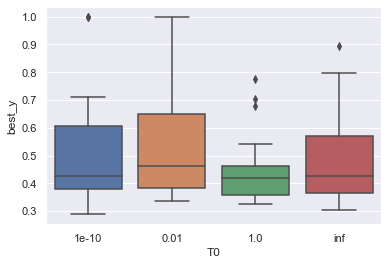

In [36]:
ax = sns.boxplot(x="T0", y="best_y", data=table_fsa)

In [37]:
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

In [38]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0   feo  mne       rel
2  FSA_1e-10_1_2_0.5  1.000000e-10  15.0  1.0  0.066667
0   FSA_0.01_1_2_0.5  1.000000e-02  30.0  1.0  0.033333
1      FSA_1_1_2_0.5  1.000000e+00   NaN  NaN  0.000000
3    FSA_inf_1_2_0.5           inf   NaN  NaN  0.000000

__CHANGE__
The results are not various. Heuristics with t_0 = 1e-2 and t_0 = 1 did not get the optimal value. 
Since FSA with small and infinite initial temperatures perfored equaly according to FEO creterium, let's analyse deeper the 

## Analysis

### Can we improve the best configuration ($T_0=1$)?

In [16]:
# maxeval 1000
heur = FastSimulatedAnnealing(n2v, maxeval=300, T0=1, n0=1, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=default_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [array([0.35799628]), 1.0, 10, 80, 10]
best_y = 0.4566929133858268


In [17]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability
log_data.head(10)

step                     x       f_x                     y       f_y  \
0     0               2.18022  0.367857  [3.1342298553846666]  0.265306   
1     1               2.18022  0.367857  [1.6785742687062073]  0.265306   
2     2  [1.6785742687062073]  0.265306   [2.205023050406567]  0.193103   
3     3  [1.6785742687062073]  0.265306  [1.5113292002405816]  0.124224   
4     4  [1.6785742687062073]  0.265306               [4.125]  0.272388   
5     5  [1.6785742687062073]  0.265306  [0.4381215189343486]  0.265306   
6     6  [0.4381215189343486]  0.265306               [0.125]  0.325581   
7     7               [0.125]  0.325581               [0.125]  0.325581   
8     8               [0.125]  0.325581               [0.125]  0.325581   
9     9               [0.125]  0.325581  [0.5208220219452003]  0.176471   

          T   swap  
0  1.000000  False  
1  0.500000   True  
2  0.200000  False  
3  0.100000  False  
4  0.058824  False  
5  0.038462   True  
6  0.027027   True  
7  0.020000   True  
8  0.015385   True  
9  0.012195  False

In [18]:
def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Step')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

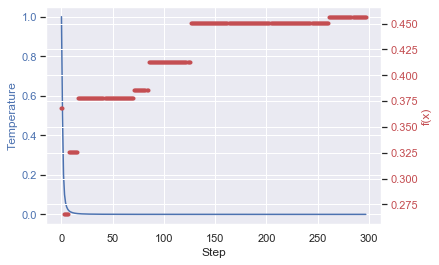

In [19]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

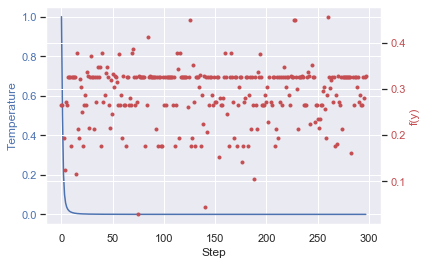

In [20]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

### Slower cooling?
Let's double $n_0$:

In [21]:
# maxeval=1000
heur = FastSimulatedAnnealing(n2v, maxeval=maxeval, T0=1, n0=2, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=default_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [1.295955566027311, 1.0, 10, 80, 10]
best_y = 0.48863636363636365


In [22]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  
# column re-ordering, for better readability

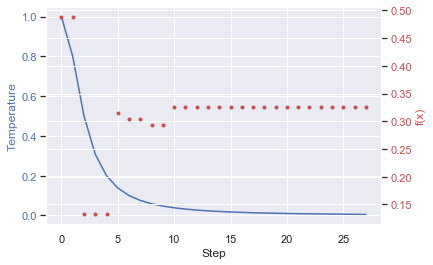

In [23]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

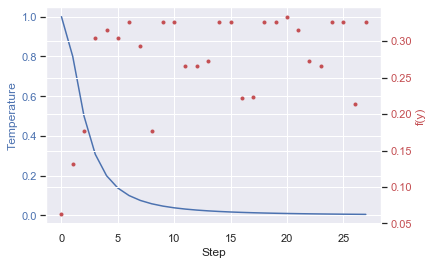

In [24]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

__More thorough testing:__

In [25]:
# cooling strategy parameter testing
for n0 in [2, 3, 5, 10]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=n0, alpha=2, r=0.5,
                        params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [26]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0   feo  mne       rel
6  FSA_1e-10_1_2_0.5  1.000000e-10   1   NaN  NaN  0.000000
0   FSA_0.01_1_2_0.5  1.000000e-02   1  30.0  1.0  0.033333
2      FSA_1_1_2_0.5  1.000000e+00   1   NaN  NaN  0.000000
3      FSA_1_2_2_0.5  1.000000e+00   2   NaN  NaN  0.000000
4      FSA_1_3_2_0.5  1.000000e+00   3  15.0  1.0  0.066667
5      FSA_1_5_2_0.5  1.000000e+00   5   NaN  NaN  0.000000
1     FSA_1_10_2_0.5  1.000000e+00  10   NaN  NaN  0.000000
7    FSA_inf_1_2_0.5           inf   1   NaN  NaN  0.000000

__Is the mutation $r$ adequate?__

In [27]:
log_data['jump_length'] = log_data.apply(lambda r: np.linalg.norm(r['x'] - r['y']), axis=1)
log_data.head(10)

step                     x       f_x                      y       f_y  \
0     0               1.29596  0.488636   [1.3139643504013128]  0.062500   
1     1               1.29596  0.488636   [1.4338008906831774]  0.132075   
2     2  [1.4338008906831774]  0.132075  [0.49758168671417313]  0.176471   
3     3  [1.4338008906831774]  0.132075   [1.1186121681404286]  0.303571   
4     4  [1.4338008906831774]  0.132075   [0.9479909424317611]  0.315436   
5     5  [0.9479909424317611]  0.315436    [0.530533513343957]  0.303571   
6     6   [0.530533513343957]  0.303571                [0.125]  0.325581   
7     7   [0.530533513343957]  0.303571   [0.7063559764595055]  0.293478   
8     8  [0.7063559764595055]  0.293478   [1.0995462499548292]  0.176471   
9     9  [0.7063559764595055]  0.293478                [0.125]  0.325581   

          T   swap  jump_length  
0  1.000000  False     0.018009  
1  0.800000   True     0.137845  
2  0.500000  False     0.936219  
3  0.307692  False     0.315189  
4  0.200000   True     0.485810  
5  0.137931   True     0.417457  
6  0.100000  False     0.405534  
7  0.075472   True     0.175822  
8  0.058824  False     0.393190  
9  0.047059   True     0.581356

In [28]:
log_data['jump_length'].describe()

count    28.000000
mean      0.725572
std       1.156428
min       0.000000
25%       0.000000
50%       0.344652
75%       0.633347
max       4.000000
Name: jump_length, dtype: float64

In [30]:
for r in [0.001,0.01,.1, .25, .75, 1]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=5, alpha=2, r=r,
                        params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [31]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0', 'r'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0      r   feo  mne       rel
12  FSA_1e-10_1_2_0.5  1.000000e-10   1  0.500   NaN  NaN  0.000000
0    FSA_0.01_1_2_0.5  1.000000e-02   1  0.500  30.0  1.0  0.033333
2       FSA_1_1_2_0.5  1.000000e+00   1  0.500   NaN  NaN  0.000000
3       FSA_1_2_2_0.5  1.000000e+00   2  0.500   NaN  NaN  0.000000
4       FSA_1_3_2_0.5  1.000000e+00   3  0.500  15.0  1.0  0.066667
5     FSA_1_5_2_0.001  1.000000e+00   5  0.001  30.0  1.0  0.033333
6      FSA_1_5_2_0.01  1.000000e+00   5  0.010   NaN  NaN  0.000000
7       FSA_1_5_2_0.1  1.000000e+00   5  0.100  30.0  1.0  0.033333
8      FSA_1_5_2_0.25  1.000000e+00   5  0.250   NaN  NaN  0.000000
9       FSA_1_5_2_0.5  1.000000e+00   5  0.500   NaN  NaN  0.000000
10     FSA_1_5_2_0.75  1.000000e+00   5  0.750   NaN  NaN  0.000000
11        FSA_1_5_2_1  1.000000e+00   5  1.000  30.0  1.0  0.033333
1      FSA_1_10_2_0.5  1.000000e+00  10  0.500   NaN  NaN  0.000000
13    FSA_inf_1_2_0.5           inf   1  0.500   NaN  NaN  0.000000

The best performing instance of FSA, according to $FEO$:

In [32]:
stats_fsa.sort_values(by=['feo']).head(1)

heur   T0  n0    r   feo  mne       rel
4  FSA_1_3_2_0.5  1.0   3  0.5  15.0  1.0  0.066667

## Conclusion